In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Fit a mesh via rendering

This tutorial shows how to:
- Load a mesh and textures from an `.obj` file.
- Create a synthetic dataset by rendering a textured mesh from multiple viewpoints
- Fit a mesh to the observed synthetic images using differential silhouette rendering
- Fit a mesh and its textures using differential textured rendering

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31529 sha256=7ddff03e93cfa9321851eb45baad687ec5adb4b1798d43826df21873a789b8ec
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
Trying to install wheel for PyTorch3D
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt241/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 73.4 MB/s eta 0:00:00


In [2]:
import os
import torch
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/camera_visualization.py
from camera_visualization import plot_camera_scene

--2024-10-17 17:19:35--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-10-17 17:19:35 (33.6 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]

--2024-10-17 17:19:35--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/camera_visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request se

OR if running **locally** uncomment and run the following cell:

In [ ]:
#  from utils.plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object.

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes.

**TexturesVertex** is an auxiliary datastructure for storing vertex rgb texture information about meshes.

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path.

In [4]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2024-10-17 17:19:36--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.81, 18.164.78.121, 18.164.78.72, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  1.28MB/s    in 0.2s    

2024-10-17 17:19:36 (1.28 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2024-10-17 17:19:36--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.81, 18.164.78.121, 18.164.78.72, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[=======

In [5]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh
# to its original center and scale.  Note that normalizing the target mesh,
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.


In [7]:
# Number of different viewpoints
num_views = 8

# Get a batch of viewing angles
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Point light
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize cameras
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...])


# Rasterization and shading settings for standard renderer
raster_settings = RasterizationSettings(
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Rasterization settings for differentiable rendering
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.) * sigma,
    faces_per_pixel=50,
    perspective_correct=False,
)

raster_settings_silhouette = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Create standard renderer
renderer_std = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

# Create log renderer
renderer_log = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights
    )
)


# Create differentiable soft renderer
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights
    )
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Create target images

meshes = mesh.extend(num_views)
gt_rgb = renderer_std(meshes, cameras=cameras, lights=lights)
gt_cameras = cameras.get_camera_center()
# Render silhouette images.  The 3rd channel of the rendering output is
# the alpha/silhouette channel
gt_silhouette = renderer_silhouette(meshes, cameras=cameras, lights=lights)

In [10]:
import os
from PIL import Image
import numpy as np

def read_png_images_to_rgb(folder_path):
    # List to store the RGB numpy arrays
    images_rgb = []

    # Loop over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):  # Check if the file is a PNG
            # Create the full path to the image file
            image_path = os.path.join(folder_path, filename)
            print(filename)

            # Open the image file using PIL
            with Image.open(image_path) as img:
                # Ensure the image is in RGB format
                img_rgb = img.convert("RGBA")

                # Convert the image to a numpy array and add to the list
                images_rgb.append(np.array(img_rgb))

    return np.array(images_rgb)
gt_images = read_png_images_to_rgb("./data/st")
gt_images = torch.tensor(gt_images, device=device)
gt_images.shape


s7.png
s2.png
s8.png
s1.png
s5.png
s3.png
s4.png
s6.png


torch.Size([8, 128, 128, 4])

In [11]:
import torch
from pytorch3d.renderer import look_at_view_transform

def points_to_pytorch3d_RT(points):
    """
    Given n points, compute PyTorch3D rotation (R) and translation (T) matrices.
    All cameras will be looking at the origin.

    Args:
        points (torch.Tensor): A tensor of shape (n, 3) representing the positions of n cameras.

    Returns:
        R (torch.Tensor): A tensor of shape (n, 3, 3) representing the rotation matrices.
        T (torch.Tensor): A tensor of shape (n, 3) representing the translation vectors.
    """
    # Ensure points is a torch tensor
    if not isinstance(points, torch.Tensor):
        points = torch.tensor(points, dtype=torch.float32)

    # Get the number of points
    n = points.shape[0]

    # Calculate distance from the origin for each point
    dist = torch.norm(points, dim=1)

    # Calculate elevation and azimuth for each point
    elev = torch.asin(points[:, 2] / dist) * 180.0 / torch.pi
    azim = torch.atan2(points[:, 1], points[:, 0]) * 180.0 / torch.pi

    # Use look_at_view_transform to compute R and T
    R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim, device=points.device)

    return R, T
# gt_images =
# gt_rgb = torch.tensor(gt_images[..., :3])
# gt_silhouette = torch.tensor(gt_images[..., 3]).reshape(8, 128, 128, 1)
gt_cameras = 3 * torch.tensor([[-0.5, 1.0,-0.5],
                           [0.5, -1, 0.5],
                           [1.0, 0.5, -1.0],
                           [-1.0, 0.5, -1.0],
                           [0, 0.5, -1.0],
                           [1.0, -0.5, -0.5],
                           [0, 1.0, -0.5],
                           [1.0, 0, 1.0]], device=device)
R, T = points_to_pytorch3d_RT(gt_cameras)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...])

Visualize the dataset:

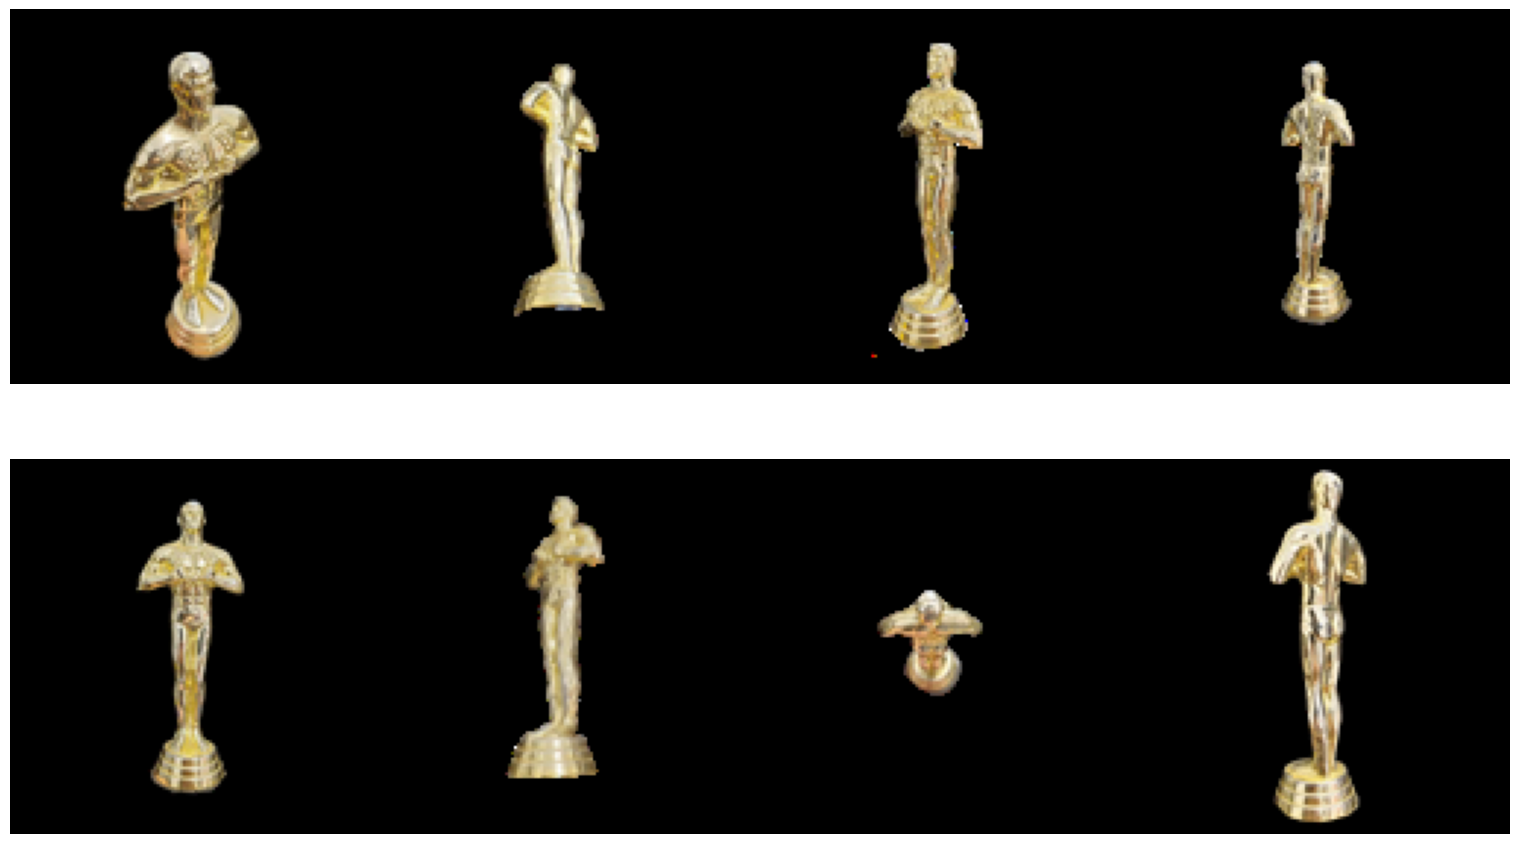

In [13]:
# RGB images
image_grid(gt_images.cpu().numpy(), rows=2, cols=4, rgb=True)
plt.show()

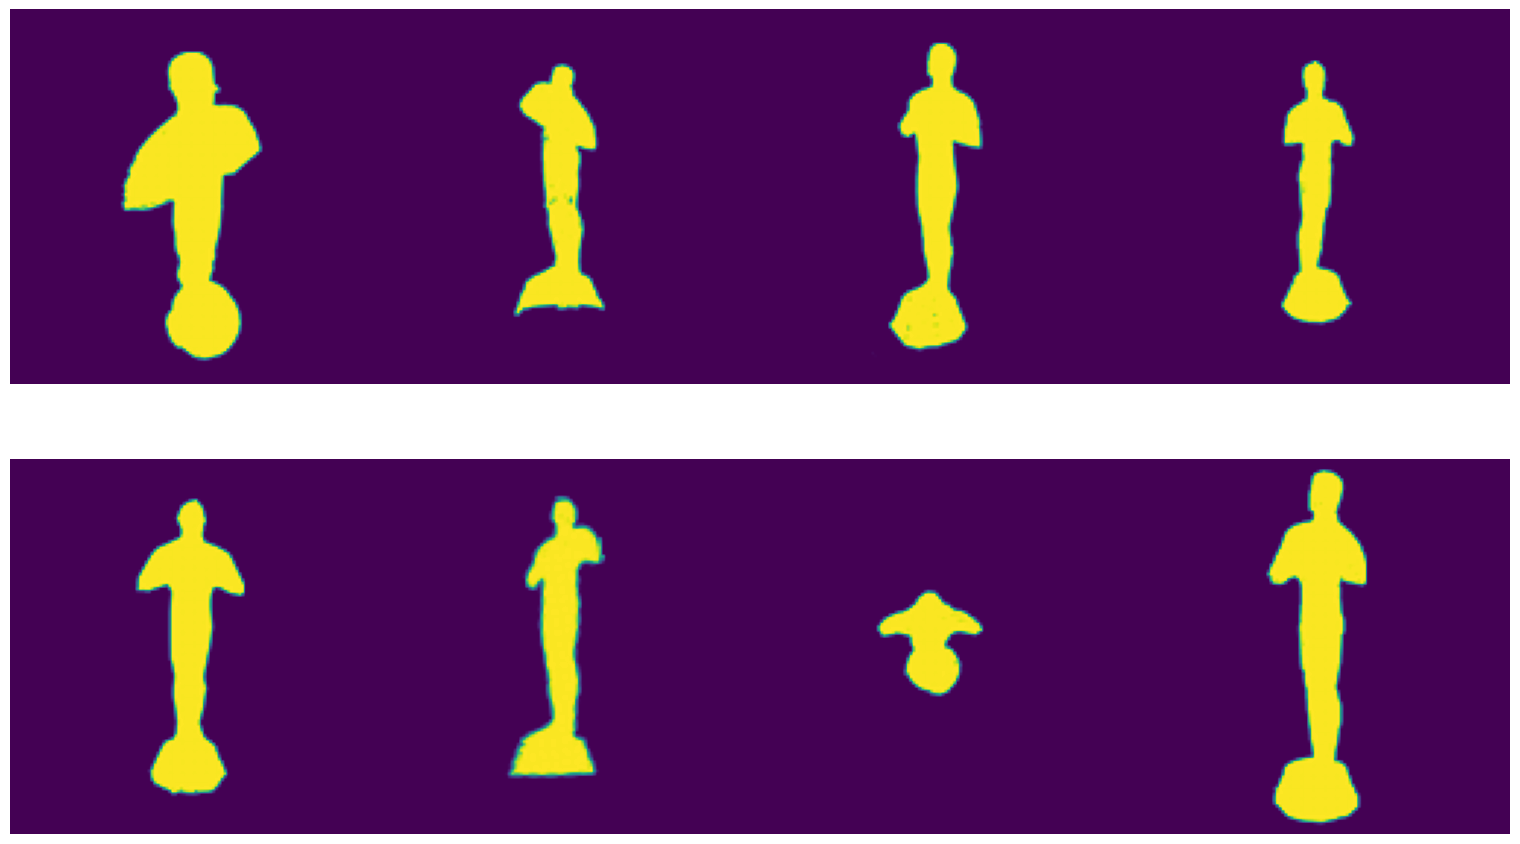

In [14]:
# Visualize silhouette images
image_grid(gt_images.cpu().numpy(), rows=2, cols=4, rgb=False)
plt.show()

In [15]:
# Show a visualization comparing the rendered predicted mesh to the ground truth
# mesh
def visualize_prediction(predicted_mesh,
                         target_image=gt_rgb[1], title=''):
    with torch.no_grad():
        predicted_images = renderer_log(predicted_mesh, cameras=camera, lights=lights)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., :3].cpu().detach().numpy())
    plt.title('Predicted')

    plt.subplot(1, 2, 2)
    plt.imshow(target_image[..., :3].cpu().detach().numpy())
    plt.title('Groundtruth')

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

In [30]:
# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)
import torch.nn as nn

# Initialize predicted cameras and mesh
perturbation = 0.0
pred_camera_pts = nn.Parameter(gt_cameras.clone() + perturbation * torch.randn_like(gt_cameras))
src_mesh = ico_sphere(2, device)
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)
sphere_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# Optimizer
optimizer = torch.optim.Adam([pred_camera_pts, deform_verts, sphere_verts_rgb], lr=0.001)

# Loss function
losses = {"rgb": {"weight": 1.0, "values": []},
          "silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.5, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }
# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0/2000, Loss: 990.2284545898438


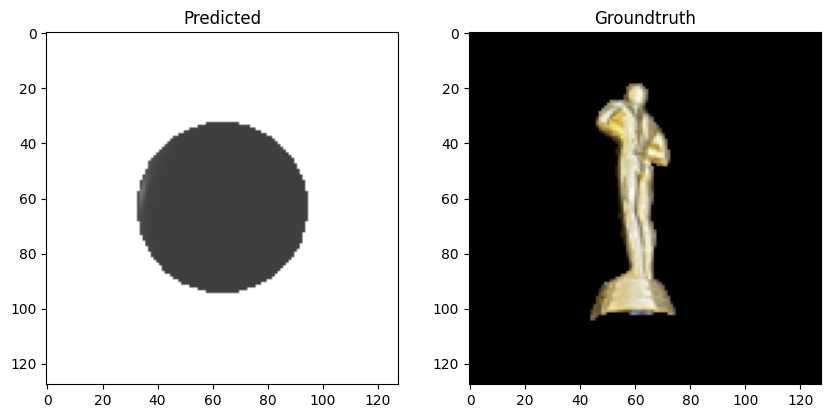

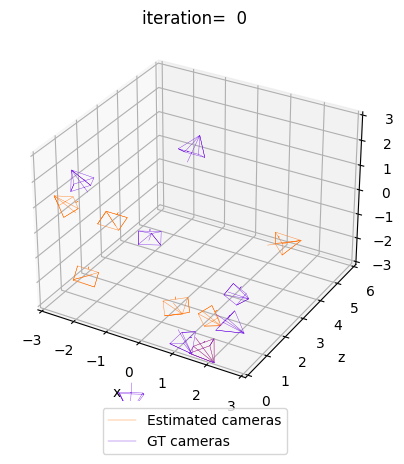

Iteration 100/2000, Loss: 989.5787963867188


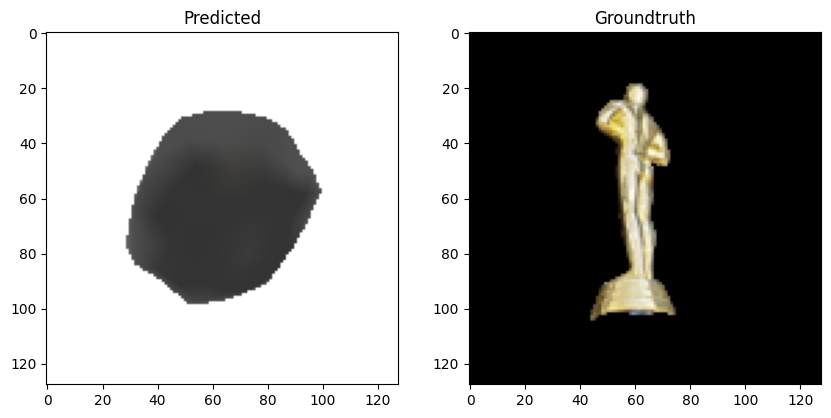

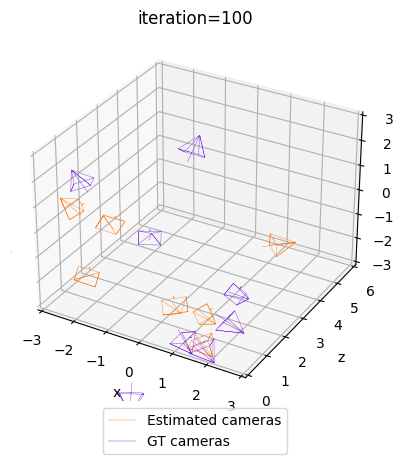

Iteration 200/2000, Loss: 988.8145751953125


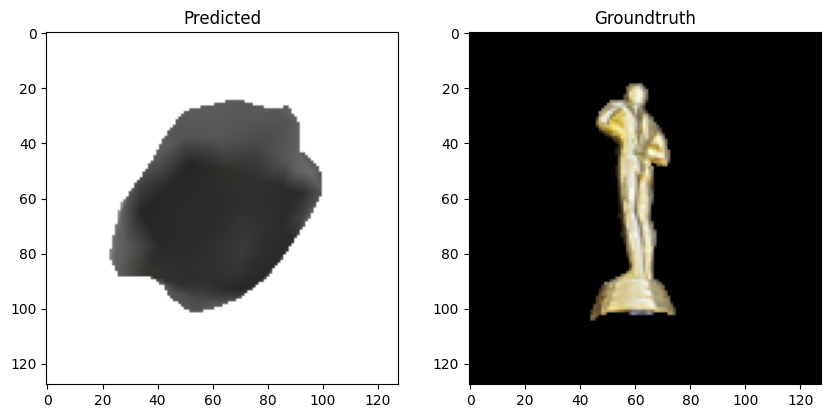

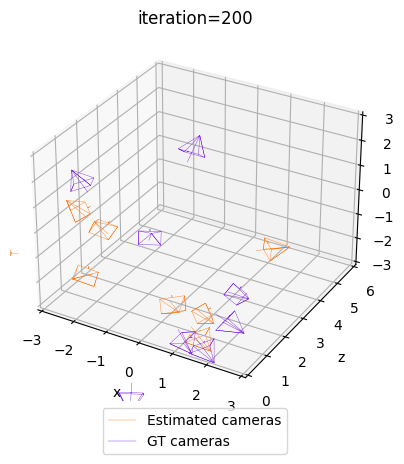

Iteration 300/2000, Loss: 988.1810913085938


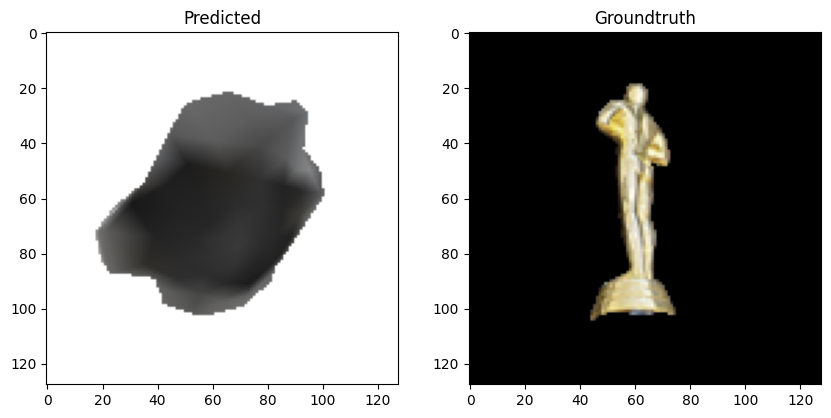

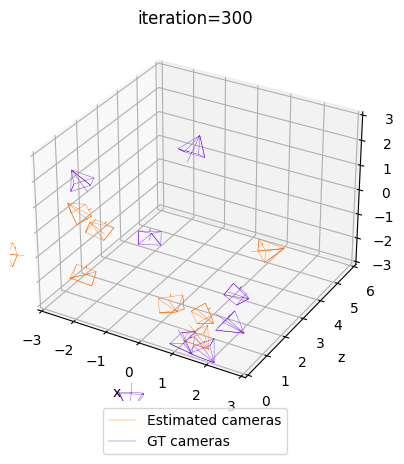

Iteration 400/2000, Loss: 987.669677734375


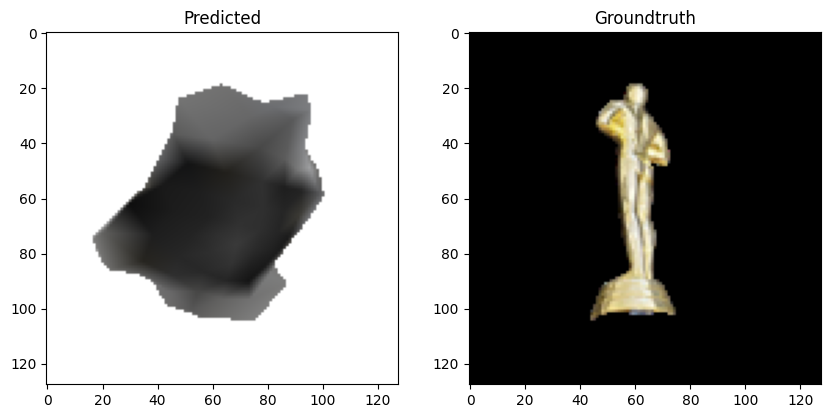

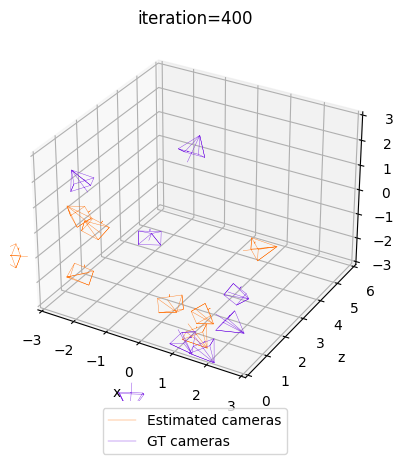

Iteration 500/2000, Loss: 987.1414794921875


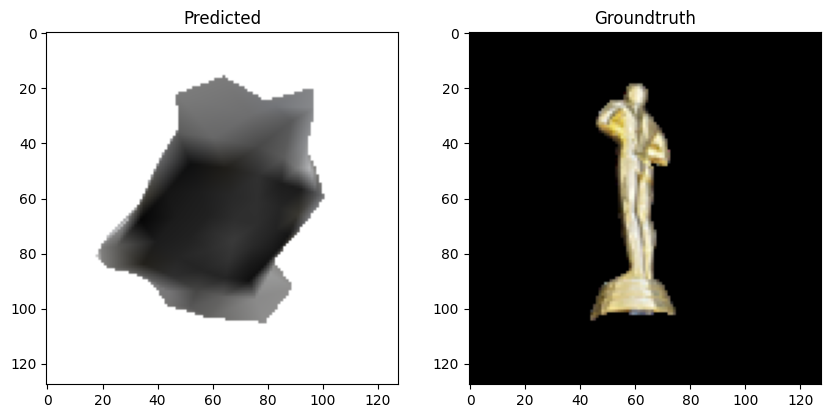

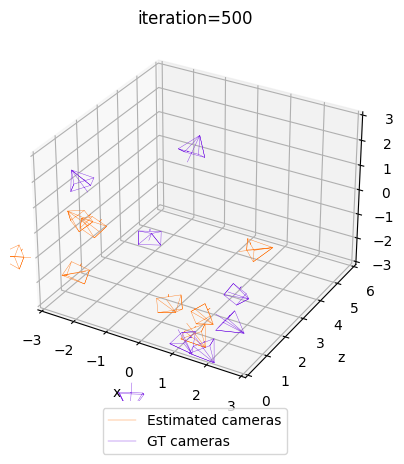

Iteration 600/2000, Loss: 986.6600952148438


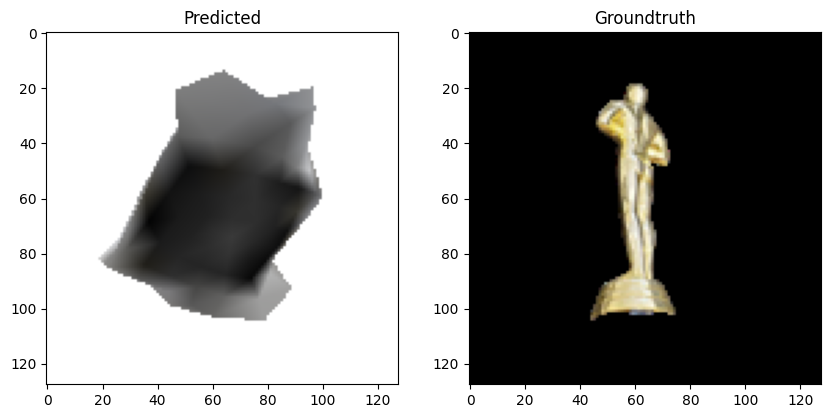

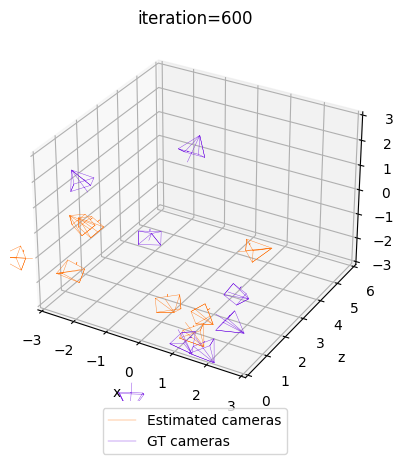

Iteration 700/2000, Loss: 986.1793212890625


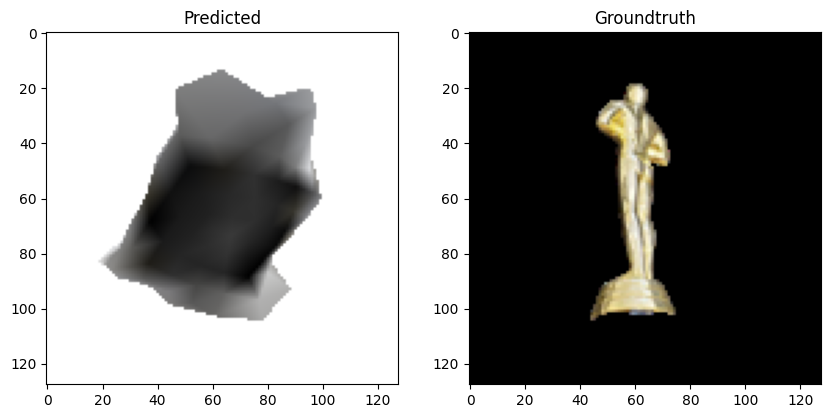

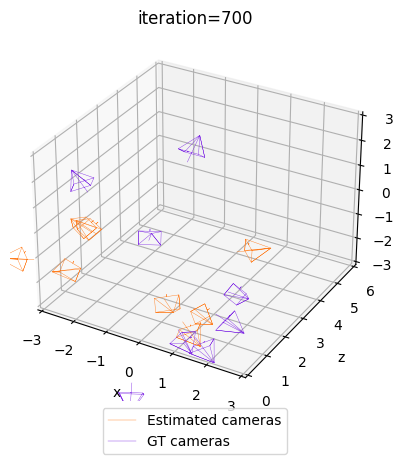

Iteration 800/2000, Loss: 985.7094116210938


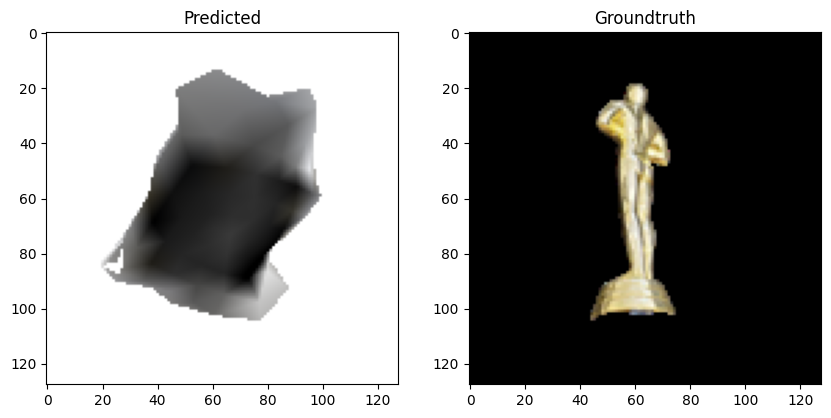

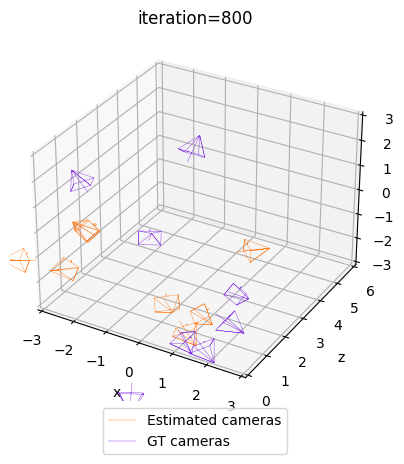

Iteration 900/2000, Loss: 985.2247314453125


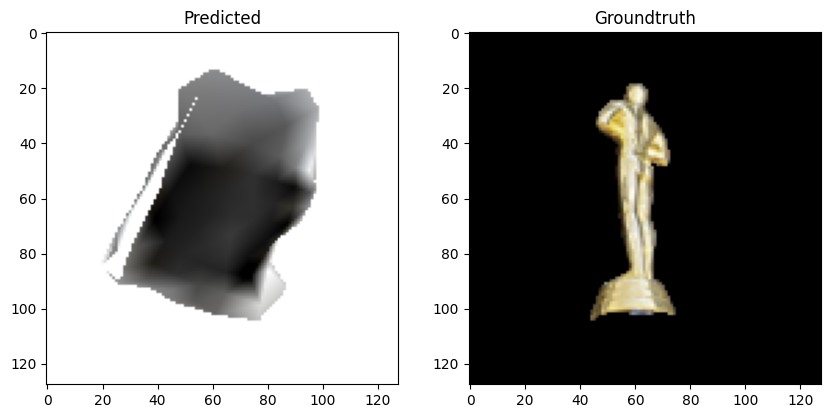

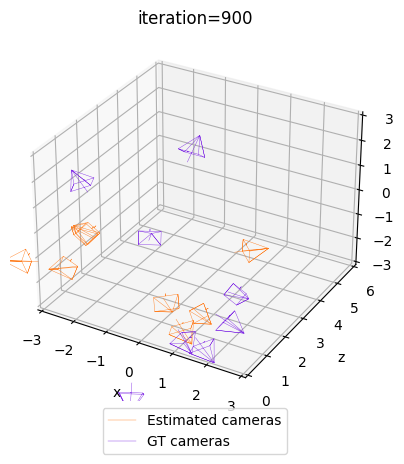

Iteration 1000/2000, Loss: 984.7042236328125


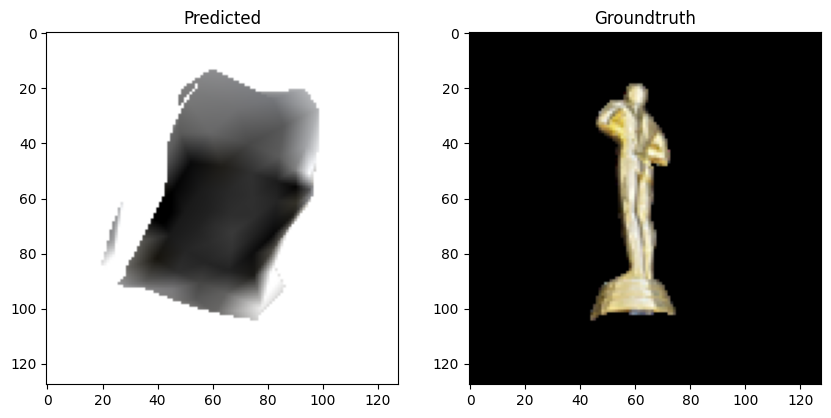

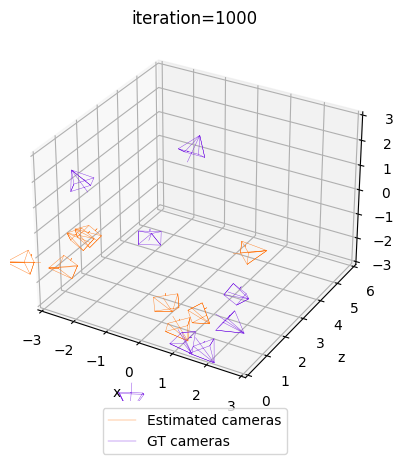

Iteration 1100/2000, Loss: 984.2381591796875


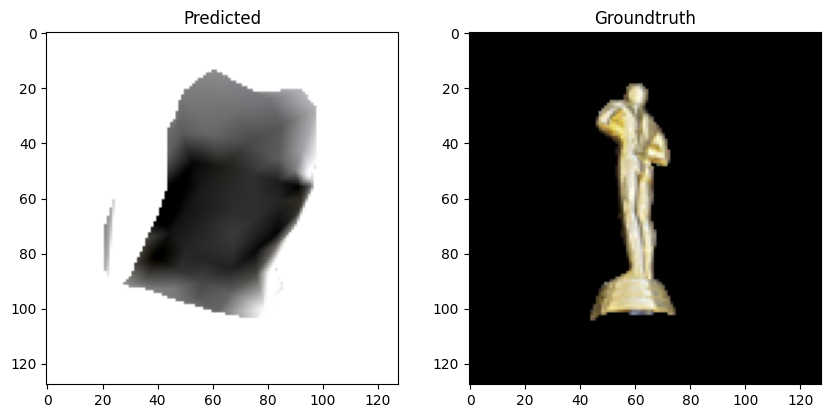

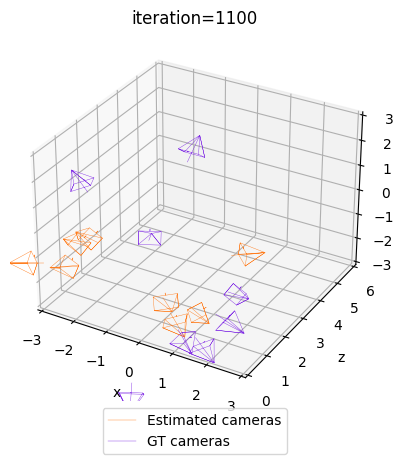

Iteration 1200/2000, Loss: 983.7828369140625


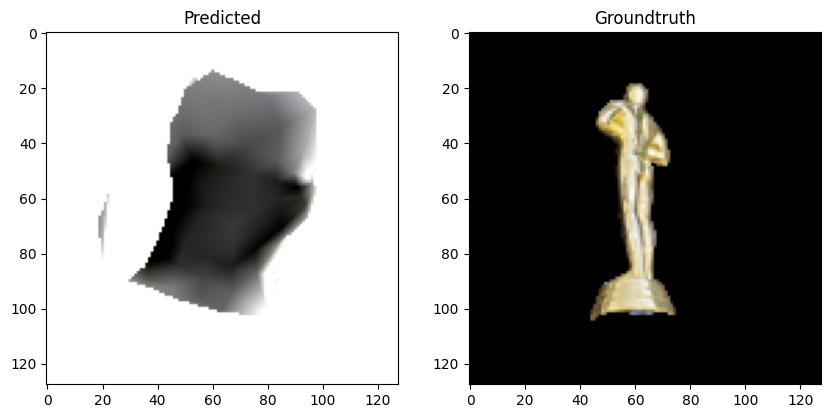

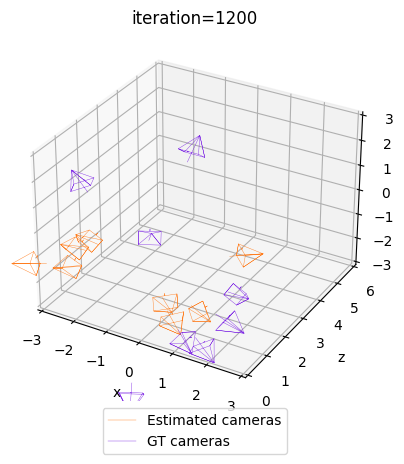

Iteration 1300/2000, Loss: 983.325439453125


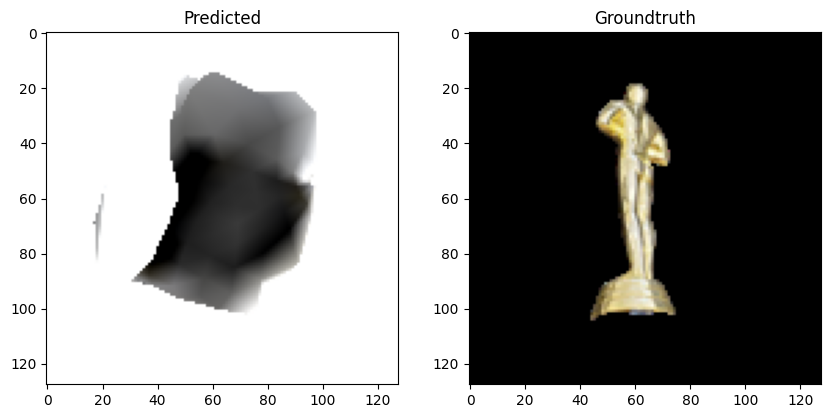

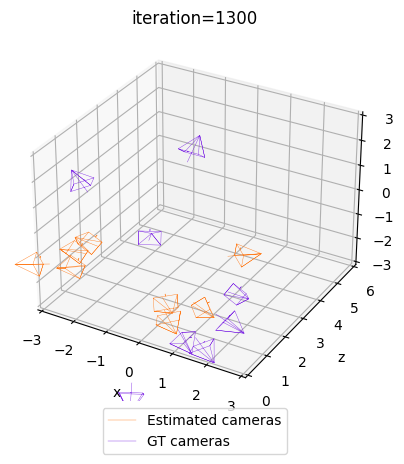

Iteration 1400/2000, Loss: 982.8541870117188


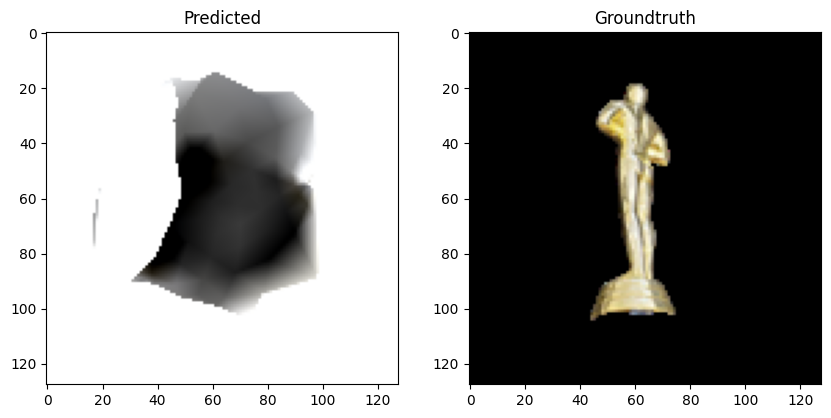

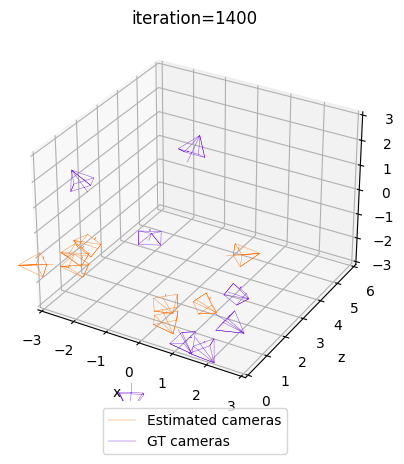

Iteration 1500/2000, Loss: 982.4102783203125


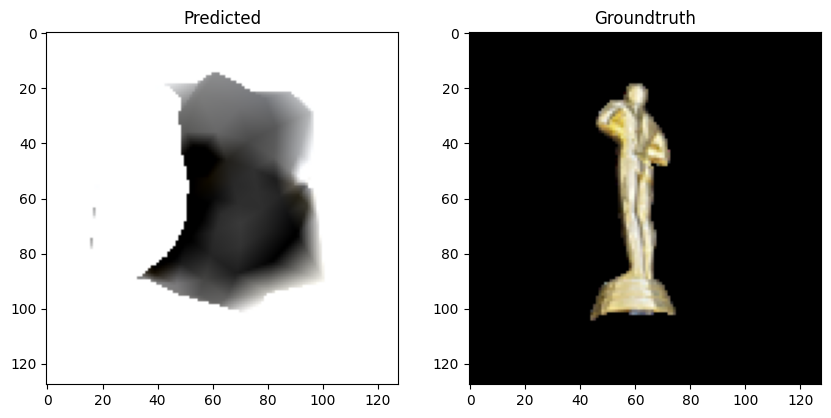

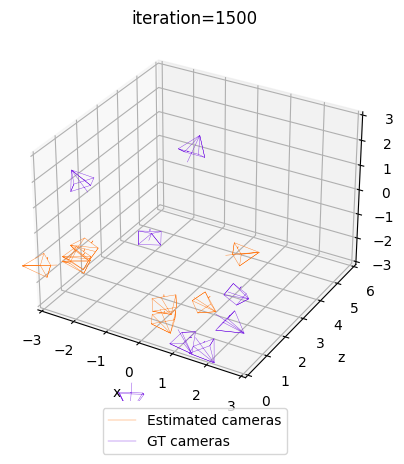

Iteration 1600/2000, Loss: 981.9923095703125


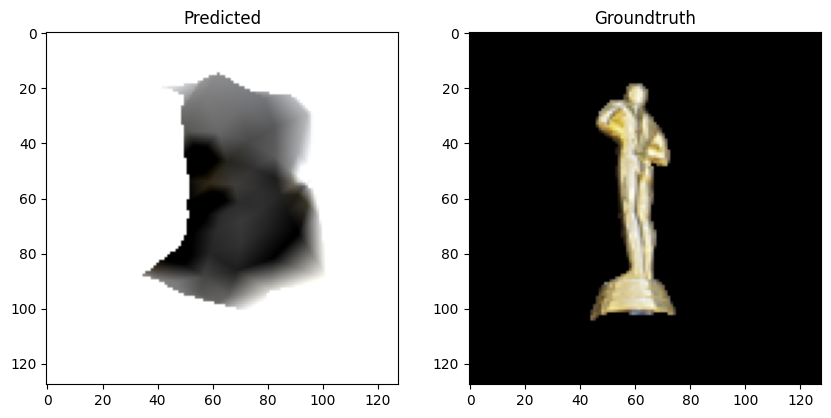

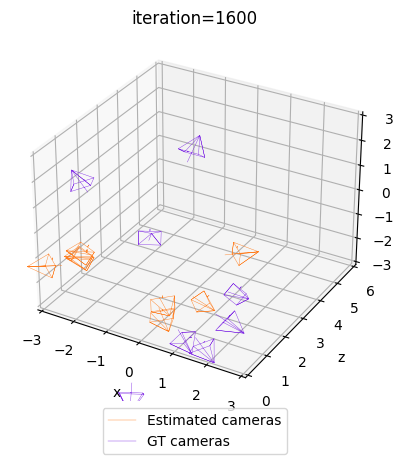

Iteration 1700/2000, Loss: 981.6349487304688


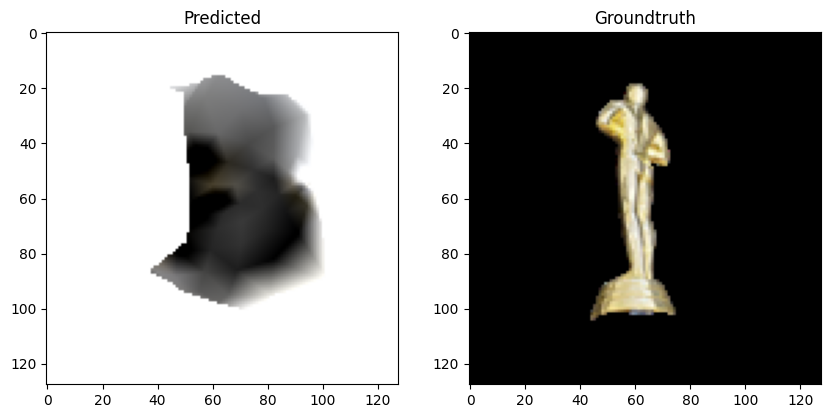

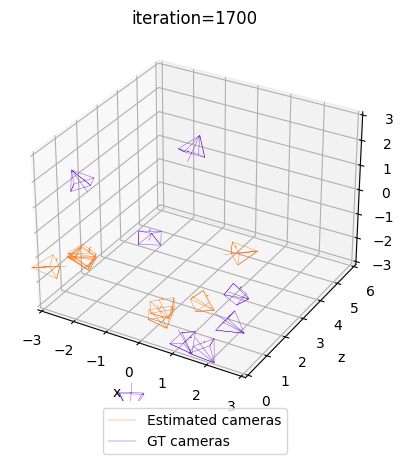

Iteration 1800/2000, Loss: 981.2762451171875


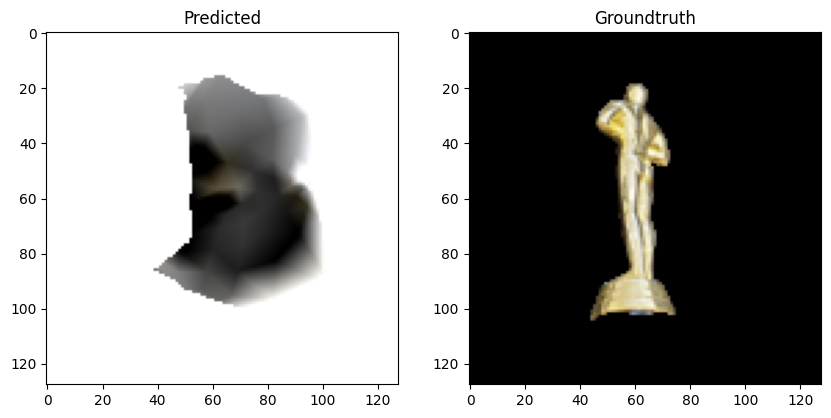

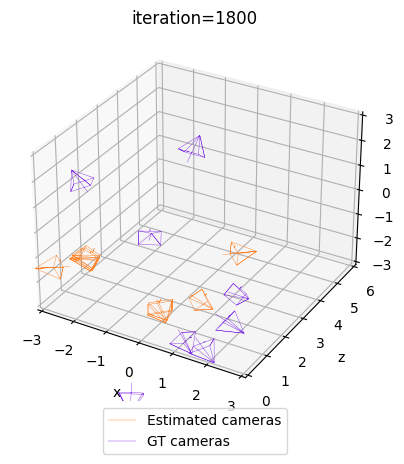

Iteration 1900/2000, Loss: 980.8997192382812


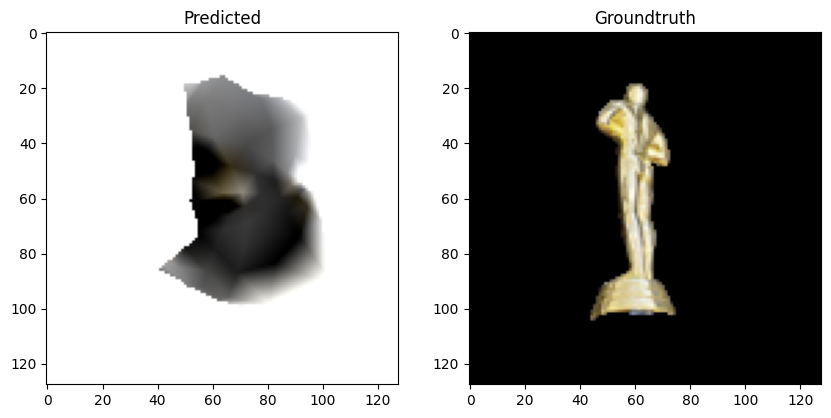

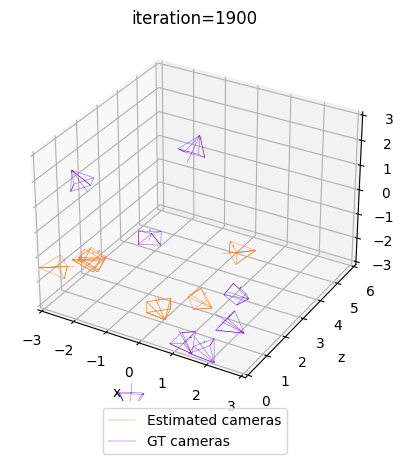

Optimization complete!


In [31]:
import imageio
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# Bundle adjustment optimization loop
writer1 = imageio.get_writer("./bundle_adj_demo_newcams.gif", mode='I', duration=0.5)
writer2 = imageio.get_writer("./bundle_adj_demo_gtcams.gif", mode='I', duration=0.5)
writer3 = imageio.get_writer("./bundle_adj_demo_cams_mov.gif", mode='I', duration=0.5)

num_iterations = 2000
plot_period = 100
for i in tqdm(range(num_iterations)):
    # Initialize the optimizer
    optimizer.zero_grad()
    # Create new mesh with predicted vertices
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb)
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    # Create cameras with predicted parameters
    new_R = look_at_rotation(pred_camera_pts, device=device)
    new_T = -torch.bmm(new_R.transpose(1,2), pred_camera_pts[:, :, None])[:, :, 0]
    new_cameras = FoVPerspectiveCameras(device=device, R=new_R, T=new_T)
    images = renderer_textured(new_src_mesh.extend(num_views), cameras=new_cameras, lights=lights)


    # Silhouette loss
    loss_silhouette = ((images[..., 3] - gt_images[...,3]) ** 2).mean()
    loss["silhouette"] += loss_silhouette / num_views
    # Squared L2 distance between the predicted RGB image and the target
    # image from our dataset
    loss_rgb = ((images[..., :3] - gt_images[..., :3]) ** 2).mean()
    loss["rgb"] += loss_rgb / num_views
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    # Print loss
    if i % plot_period == 0:
        print(f"Iteration {i}/{num_iterations}, Loss: {sum_loss}")
        visualize_prediction(new_src_mesh, title="iter: %d" % i, target_image=gt_images[1])
        # make a 4 x 2 image grid, pad the 8-view images into it
        # Convert images to numpy format and create a 4x2 grid
        images_np = images[..., :3].cpu().detach().numpy()  # Get RGB channels
        images_np = (images_np * 255).astype(np.uint8)  # Convert to uint8 format

        fig, axes = plt.subplots(4, 2, figsize=(8, 8))
        for idx, ax in enumerate(axes.flat):
            ax.imshow(images_np[idx])
            ax.axis('off')

        # Save the grid image to a buffer
        fig.canvas.draw()
        grid_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        grid_image = grid_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)

        # Write the grid image to the GIF writer
        writer1.append_data(grid_image)

        images_gt = renderer_textured(new_src_mesh.extend(num_views), cameras=cameras, lights=lights)
        images_np = images_gt[..., :3].cpu().detach().numpy()  # Get RGB channels
        images_np = (images_np * 255).astype(np.uint8)  # Convert to uint8 format

        fig, axes = plt.subplots(4, 2, figsize=(8, 8))
        for idx, ax in enumerate(axes.flat):
            ax.imshow(images_np[idx])
            ax.axis('off')

        # Save the grid image to a buffer
        fig.canvas.draw()
        grid_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        grid_image = grid_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)

        # Write the grid image to the GIF writer
        writer2.append_data(grid_image)

        status = 'iteration=%3d' % (i)
        fig = plot_camera_scene(new_cameras, cameras, status)
        fig.canvas.draw()
        grid_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        grid_image = grid_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)

        writer3.append_data(grid_image)


    # Step the optimizer
    sum_loss.backward()
    optimizer.step()
writer1.close()
writer2.close()
writer3.close()
print("Optimization complete!")

In [32]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene


fig = plot_scene({
    "subplot1": {
        "groundtruth": mesh
    },
    "subplot2": {
        "predicted": new_src_mesh
    }
})
fig.show()